In [ ]:
!pip install pyspark

Importing necessary libraries.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #plot graphs
#from sklearn.preprocessing import LabelEncoder 
from pyspark.sql import SparkSession
from pandas.plotting import scatter_matrix

Spark Session and importing CSV - Breast cancer dataset - Breast Cancer Wisconsin (Diagnostic) Data Set
About the dataset:
1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter) 
b) texture (standard deviation of gray-scale values) 
c) perimeter 
d) area 
e) smoothness (local variation in radius lengths) 
f) compactness (perimeter^2 / area - 1.0) 
g) concavity (severity of concave portions of the contour) 
h) concave points (number of concave portions of the contour) 
i) symmetry 
j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [3]:
spark = SparkSession.builder.appName('bda_mini').getOrCreate()
data = spark.read.csv('data.csv', header = True, inferSchema = True)
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- radius_se: double (nullable = true)
 |-- texture_se: double (nullable = true)
 |-- perimeter_se: double (nullable = true)
 |-- area_se: double (nullable = true)
 |-- smoothness_se: double (nullable = true)
 |-- compactness_se: double (nullable = true)
 |-- concavity_se: double (nullable = true)
 |-- concave points_se: double (nullable = true)
 |-- symmetry_se: double (nullable = true)
 |-- fractal_dimension_se: double (nullable = true)
 |-- radi

Just checking the data out - getting familiar with it.

In [4]:
pd.DataFrame(data.take(5), columns=data.columns).transpose()

,0,1,2,3,4
id,842302,842517,84300903,84348301,84358402
diagnosis,M,M,M,M,M
radius_mean,17.99,20.57,19.69,11.42,20.29
texture_mean,10.38,17.77,21.25,20.38,14.34
perimeter_mean,122.8,132.9,130,77.58,135.1
area_mean,1001,1326,1203,386.1,1297
smoothness_mean,0.1184,0.08474,0.1096,0.1425,0.1003
compactness_mean,0.2776,0.07864,0.1599,0.2839,0.1328
concavity_mean,0.3001,0.0869,0.1974,0.2414,0.198
concave points_mean,0.1471,0.07017,0.1279,0.1052,0.1043


The last column (_c32) seems to have None values only. Will have to remove it later.

Finding numeric features - other than label - diagnosis, and _c32 , everything else is numeric (double)

In [5]:
numeric_features = [t[0] for t in data.dtypes if t[1] == 'double']
data.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
radius_mean,569,14.127291739894563,3.5240488262120793,6.981,28.11
texture_mean,569,19.28964850615117,4.301035768166948,9.71,39.28
perimeter_mean,569,91.96903339191566,24.2989810387549,43.79,188.5
area_mean,569,654.8891036906857,351.9141291816529,143.5,2501.0
smoothness_mean,569,0.096360281195079,0.014064128137673616,0.05263,0.1634
compactness_mean,569,0.10434098418277686,0.0528127579325122,0.01938,0.3454
concavity_mean,569,0.08879931581722322,0.07971980870789354,0.0,0.4268
concave points_mean,569,0.048919145869947236,0.03880284485915361,0.0,0.2012
symmetry_mean,569,0.181161862917399,0.027414281336035712,0.106,0.304


In [13]:
cols = data.columns
len(cols)

33

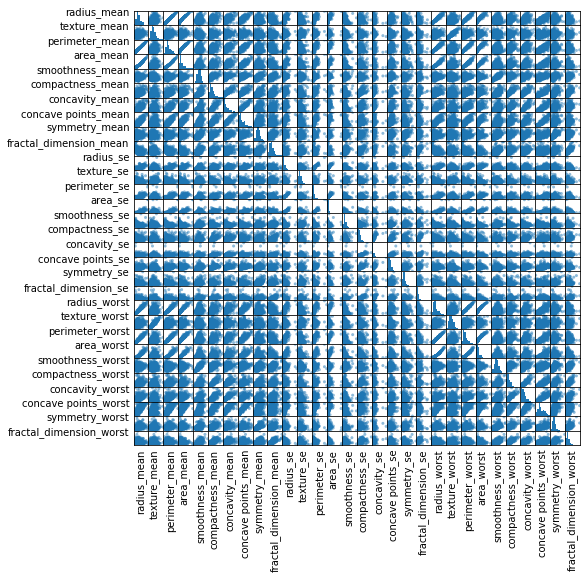

In [14]:
numeric_data = data.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

checking Correlation - if positive/negative and close to 1/-1- removed that column
Removing columns that we dont really need - they seem repetitive
For example:
radius_mean - area_mean - Perimeter_mean - really stand out how similar they are

In [15]:
len(numeric_data.columns)

30

In [17]:
cols=data.columns
rm = ['id','diagnosis','perimeter_mean','area_mean','concave points_mean','radius_worst','texture_worst','perimeter_worst','area_worst','compactness_worst','_c32']
for i in rm: 
    cols.remove(i)
len(cols)

22

In [ ]:
data.printSchema()

In [ ]:
numeric_data

Import Vector assembler and transform dataset into a vector with the shortlisted features.

In [18]:
# Let us import the vector assembler
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=cols,outputCol="feature")
# Now let us use the transform method to transform our dataset
data=assembler.transform(data)
data.select("feature").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|feature                                                                                                                                                              |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[17.99,10.38,0.1184,0.2776,0.3001,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,0.1622,0.7119,0.2654,0.4601,0.1189]      |
|[20.57,17.77,0.08474,0.07864,0.0869,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.0186,0.0134,0.01389,0.003532,0.1238,0.2416,0.186,0.275,0.08902]      |
|[19.69,21.25,0.1096,0.1599,0.1974,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.00615,0.04006,0.03832,0.02058,0.0225,0.004571,0.1444,0.4504,0.243,0.3613,0.08758] 

Now we will scale the features using StandardScaler

In [19]:
from pyspark.ml.feature import StandardScaler
standardscaler=StandardScaler().setInputCol("feature").setOutputCol("Scaled_features")
data=standardscaler.fit(data).transform(data)
data.select("feature","Scaled_features").show(5)

+--------------------+--------------------+
|             feature|     Scaled_features|
+--------------------+--------------------+
|[17.99,10.38,0.11...|[5.10492359418783...|
|[20.57,17.77,0.08...|[5.83703603849048...|
|[19.69,21.25,0.10...|[5.58732326679035...|
|[11.42,20.38,0.14...|[3.24059074183574...|
|[20.29,14.34,0.10...|[5.75758197476771...|
+--------------------+--------------------+
only showing top 5 rows



Diagnosis column is Categorical, we will need to convert it to numerical values.

In [27]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="diagnosis", outputCol="label")
indexed = indexer.fit(data).transform(data)
indexed.show(5)

+--------+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+----+--------------------+--------------------+-----+
|      id|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_wo

Last column - label has been added - 1 --> Malignant  0 ---> Benign

Now we will split the dataset into train set and test set (80% 20%)
seed ensures that the sampling on the same dataset executed several times will always return the same results

In [30]:
train, test = indexed.randomSplit([0.8, 0.2], seed=12345)

Check the percentage of positives - we need a balance right?

In [31]:
dataset_size=float(train.select("label").count())
numPositives=train.select("label").where('label == 1.0').count()
per_ones=(float(numPositives)/float(dataset_size))*100
numNegatives=float(dataset_size-numPositives)
print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))

The number of ones are 171
Percentage of ones are 38.084632516703785


38% -- not balanced

In [32]:
BalancingRatio= numNegatives/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

BalancingRatio = 0.6191536748329621


In [33]:
from pyspark.sql.functions import when
train=train.withColumn("classWeights", when(train.label == 1,BalancingRatio).otherwise(1-BalancingRatio))
train.select("classWeights").show(5)

+-------------------+
|       classWeights|
+-------------------+
| 0.6191536748329621|
|0.38084632516703787|
|0.38084632516703787|
|0.38084632516703787|
| 0.6191536748329621|
+-------------------+
only showing top 5 rows



Selecting Features

In [34]:
# Feature selection using chisquareSelector
from pyspark.ml.feature import ChiSqSelector
css = ChiSqSelector(featuresCol='Scaled_features',outputCol='Aspect',labelCol='label',fpr=0.05)
train=css.fit(train).transform(train)
test=css.fit(test).transform(test)
test.select("Aspect").show(5,truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Aspect                                                                                                                                                                                                                                                                                                                                                                                                                    |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<h1> Logistic Regression </h1>

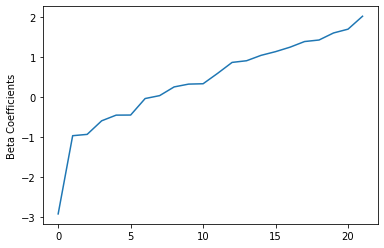

In [35]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="label", featuresCol="Aspect",weightCol="classWeights",maxIter=10)
model=lr.fit(train)
beta = np.sort(model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

ROC Curve - FPR - TPR

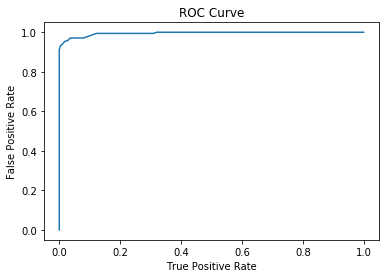

Training set areaUnderROC: 0.9950039968025579


In [37]:
trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))


Looks good for training set.

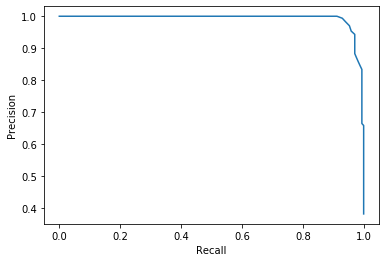

In [38]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [42]:
predict_train = model.transform(train)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  1.0|[-6.7872426329665...|       1.0|[0.00112680388722...|
|  0.0|[8.64021744682378...|       0.0|[0.99982318282691...|
|  0.0|[-0.4300189505350...|       1.0|[0.39412180636452...|
|  0.0|[6.07401122344375...|       0.0|[0.99770336552457...|
|  1.0|[-11.252498927183...|       1.0|[1.29746655993609...|
|  0.0|[10.1391820687246...|       0.0|[0.99996050046147...|
|  0.0|[4.65745441209493...|       0.0|[0.99059863370916...|
|  1.0|[-7.7238962802728...|       1.0|[4.41939166759968...|
|  0.0|[7.26988118246182...|       0.0|[0.99930428964088...|
|  0.0|[8.80990075628727...|       0.0|[0.99985077420452...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [43]:
predict_test=model.transform(test)
predict_test.select("label","prediction").show()

+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [44]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='label')
predict_test.select("label","rawPrediction","prediction","probability").show(5)
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  1.0|[-5.3180335837560...|       1.0|[0.00487846825489...|
|  1.0|[-26.463822630871...|       1.0|[3.21297881007945...|
|  0.0|[5.84288071396101...|       0.0|[0.99710791328541...|
|  1.0|[-2.9798837714490...|       1.0|[0.04834297564206...|
|  1.0|[-11.184212747476...|       1.0|[1.38915941360757...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 0.995056586309899
The area under ROC for test set is 1.0
